In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
import spacy
import scipy
from tqdm.auto import tqdm
np.float = float    

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import gensim
from sklearn.decomposition import LatentDirichletAllocation

from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import openai

# Load and Preprocess

In [3]:
def load_preprocess_df(file_path, video_date, video_title):
    ''' 
    Load scrpaed comments csv into DataFrame, preprocess column information
    Arg:
        file_path (str): input csv file path of all comments and replies in a given video
        video_date (str): the publish date of this news video, different from comment's publish date
    '''

    df = pd.read_csv(file_path)
    df.rename(columns={'PublishedAt': 'Comment PublishedAt'}, inplace=True)
    df['Comment PublishedAt'] = pd.to_datetime(df['Comment PublishedAt']) # ensure entries are DataTime
    df['Comment PublishedAt'] = df['Comment PublishedAt'].dt.strftime('%Y-%m-%d') # ignore hour/minute/second
    df['Video PublishedAt'] = pd.Timestamp(video_date)
    df['Video Title'] = video_title
    
    return df

In [4]:
# Load 2020 comment data
fox3_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2003_comments.csv', '2020-03-09', 'Tucker: We must remain calm but not complacent about the coronavirus')
fox4_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2004_comments.csv', '2020-04-10', '10 percent of US workforce now unemployed')
fox5_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2005_comments.csv', '2020-05-17', 'Gutfeld: Where were the media warnings back when coronavirus pandemic started?')
fox6_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2006_comments.csv', '2020-06-26', "Coronavirus cases are surging; Who's to blame?")
fox7_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2007_comments.csv', '2020-07-27', "Dr. Fauci says he's 'cautiously optimistic' regarding coronavirus vaccine")
fox8_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2008_comments.csv', '2020-08-11', 'Big 10 conference officially postpones 2020 football season')
fox9_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2009_comments.csv', '2020-09-15', "Coronavirus whistleblower speaks out about possible COVID origin on 'Tucker'")
fox10_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2010_comments.csv', '2020-10-11', "Trump says he no longer has coronavirus and is 'immune'")
fox11_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2011_comments.csv', '2020-11-09', 'Biden could propose national mask mandate as part of COVID-19 plan')
fox12_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2020/fox2012_comments.csv', '2020-12-27', "Judge Jeanine: Congress's incompetence over COVID relief bill")

abc1_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2001_comments.csv', '2020-01-27', 'Race to contain deadly coronavirus with 5 confirmed US cases')
abc2_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2002_comments.csv', '2020-02-24', 'Italy struggles to contain new coronavirus outbreak')
abc3_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2003_comments.csv', '2020-03-24', 'Lesson from South Korea on how to slow the COVID-19 spread')
abc4_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2004_comments.csv', '2020-04-06', 'Queen Elizabeth address public amid coronavirus outbreak')
abc5_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2005_comments.csv', '2020-05-27', 'Facing cancer during COVID-19')
abc6_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2006_comments.csv', '2020-06-25', 'Latest updates on COVID-19: June 25, 2020')
abc7_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2007_comments.csv', '2020-07-02', 'US coronavirus infections surge amid new warnings, closures | WNT')
abc8_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2008_comments.csv', '2020-08-24', "The new COVID-19 travel trend is a 'flexcation'")
abc9_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2009_comments.csv', '2020-09-22', "COVID-19 crisis threatens children's mental health")
abc10_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2010_comments.csv', '2020-10-15', 'Joe Biden pressed whether he would take a COVID-19 vaccine l ABC News Town Hall')
abc11_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2011_comments.csv', '2020-11-25', 'Thanksgiving COVID-19 warning')
abc12_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2020/abc2012_comments.csv', '2020-12-07', "Sean Penn's COVID-19 testing mission")

msnbc2_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2002_comments.csv', '2020-02-08', '13 Americans Infected With COVID-19 On Cruise Ship In Japan')
msnbc3_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2003_comments.csv', '2020-03-16', 'Historic: First Person to Test Covid Vaccine talks to Ari Melber in 2020')
msnbc4_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2004_comments.csv', '2020-03-31', "See Bill Gates' Pandemic Warnings Before Covid: Ari Melber Breakdown")
msnbc5_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2005_comments.csv', '2020-05-25', 'Global Carbon Emissions Drop By 17% Amid COVID-19 Pandemic | MTP Daily')
msnbc6_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2006_comments.csv', '2020-06-26', "Gov. Abbott's Steps 'Fall Short' Of What Texas Needs Amid Rising COVID-19 Cases")
msnbc7_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2007_comments.csv', '2020-07-08', 'Pathologist Shares Findings From Autopsies Of COVID-19 Patients | MTP Daily')
msnbc8_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2008_comments.csv', '2020-08-27', "Joy Reid On Trump Downplaying COVID-19: There's No Politician I'd Die For")
msnbc9_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2009_comments.csv', '2020-09-02', "Fauci: U.S. Must Shrink Daily COVID Case Baseline To '10,000 Or Less' | Andrea Mitchell")
msnbc10_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2010_comments.csv', '2020-10-06', 'Trump Returns To WH, Says To Not Be Afraid Of Coronavirus | Morning Joe')
msnbc11_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2011_comments.csv', '2020-11-29', "Doctor on COVID: 'Going Back To Normal Will Prolong This War'")
msnbc12_df = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2020/msnbc2012_comments.csv', '2020-12-18', "FDA Grants Emergency Authorization To Moderna's Covid-19 Vaccine | All In")

In [5]:
# Load 2021 comment data
fox1_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2101_comments.csv', '2021-01-30', 'Sen Cassidy lays out what it will take for GOP to support COVID-19 relief')
fox2_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2102_comments.csv', '2021-02-06', "COVID-19 vaccinations shouldn't be a prerequisite to reopening schools: infectious diseases expert")
fox3_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2103_comments.csv', '2021-03-05', 'Top Cuomo aides altered COVID-19 nursing death tolls: Report')
fox4_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2104_comments.csv', '2021-04-28', 'Biden, Harris called out by governors for skipping COVID calls')
fox5_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2105_comments.csv', '2021-05-31', 'Biden calls for intel report on COVID origins')
fox6_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2106_comments.csv', '2021-06-10', 'Biden to give 500M COVID vaccine doses to low-income countries')
fox7_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2107_comments.csv', '2021-07-14', "Californians 'fed up' with COVID restrictions: 'Enough is enough'")
fox8_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2108_comments.csv', '2021-08-01', "NIH director: Delta variant is a 'different virus,' could hit reset button")
fox9_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2109_comments.csv', '2021-09-09', "Gutfeld shreds Biden for 'ginning up anger' during COVID speech")
fox10_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2110_comments.csv', '2021-10-18', "'The Five' blast COVID hypocrisy from the elites")
fox11_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2111_comments.csv', '2021-11-29', "McEnany: No one has politicized the virus more than Biden")
fox12_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/fox_2021/fox2112_comments.csv', '2021-12-01', "'The Five' rip new Biden COVID restrictions")

abc1_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2101_comments.csv', '2021-01-21', "Coronavirus crisis")
abc2_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2102_comments.csv', '2021-02-22', "Remembering the lives lost to COVID-19")
abc3_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2103_comments.csv', '2021-03-24', "Some COVID-19 patients experiencing eye problems")
abc4_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2104_comments.csv', '2021-04-26', "India experiencing 'COVID tsunami'")
abc5_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2105_comments.csv', '2021-05-10', "India's healthcare system pushed to its limits as coronavirus crisis deepens")
abc6_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2106_comments.csv', '2021-06-23', "Biden expected to miss July 4th COVID vaccine goal")
abc7_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2107_comments.csv', '2021-07-20', "‘Breakthrough’ COVID cases hit the White House")
abc8_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2108_comments.csv', '2021-08-25', "Data supports booster shots increasing COVID-19 protection")
abc9_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2109_comments.csv', '2021-09-27', "Biden receives COVID Pfizer booster shot at White House")
abc10_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2110_comments.csv', '2021-10-21', "ABC News journalist makes emotional journey home to Australia")
abc11_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2111_comments.csv', '2021-11-10', "Pfizer asks FDA to approve COVID-19 boosters for ages 18 and up")
abc12_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/abc_2021/abc2112_comments.csv', '2021-12-30', "US shatters daily COVID-19 case record")

msnbc1_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2101_comments.csv', '2021-01-10', "U.S. Could Hit 1 Million COVID-19 Deaths By May 1st, Expert Believes")
msnbc2_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2102_comments.csv', '2021-02-19', "Doctors Call For Expedited Covid Vaccination Before Variants Become Widespread In U.S. | Katy Tur")
msnbc3_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2103_comments.csv', '2021-03-12', "One Year with Covid: Celebrating The Lives Of Those We Lost And Families Left Behind")
msnbc4_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2104_comments.csv', '2021-04-14', "Everything You Need To Know (And More) About Johnson & Johnson Covid Vaccine Pause | Rachel Maddow")
msnbc5_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2105_comments.csv', '2021-05-12', "Dr. Fauci Explains Emergency Use Authorization For Covid Vaccines")
msnbc6_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2106_comments.csv', '2021-06-09', "Dr. Anthony Fauci On Covid Origins, New Variant")
msnbc7_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2107_comments.csv', '2021-07-11', "There Are 'More Consequences To Covid-19 Than Just Death'")
msnbc8_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2108_comments.csv', '2021-08-11', "How A 'Mini-Trump' Is Running Florida Into The Ground Amidst Covid-19 Deaths")
msnbc9_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2109_comments.csv', '2021-09-30', "Unvaccinated Covid Patients Still Overwhelming Health Care Workers")
msnbc10_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2110_comments.csv', '2021-10-01', "California To Require Covid Vaccines For Schoolchildren")
msnbc11_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2111_comments.csv', '2021-11-12', "For Facts Sake: Nearly A Million Children Vaccinated For Covid-19")
msnbc12_df1 = load_preprocess_df('/Users/itsyuzhou/Winter2024/MA_thesis/youtube_comments/comments/msnbc_2021/msnbc2112_comments.csv', '2021-12-28', "Puerto Rico Covid Cases Soar Nearly 2800% In Two Weeks")

In [6]:
ex_df = pd.concat([msnbc11_df1[:2], msnbc12_df1[:2]], axis=0, ignore_index=True)
ex_df

,Comment PublishedAt,Comment,Video PublishedAt,Video Title
0,2022-06-15,These people are sick trash anyone thinking of...,2021-11-12,For Facts Sake: Nearly A Million Children Vacc...
1,2022-02-03,More children drown EVERY year than die from C...,2021-11-12,For Facts Sake: Nearly A Million Children Vacc...
2,2022-10-17,That’s Rican’s for ya 😷😷😷😷😷😷😷😷,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...
3,2022-02-12,Remember vaccines are safe and effective. safe...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...


In [7]:
fox_dfs = [fox3_df,fox4_df,fox5_df,fox6_df,fox7_df,fox8_df,fox9_df,fox10_df,fox11_df,fox12_df,fox1_df1,fox2_df1,fox3_df1,fox4_df1,fox5_df1,fox6_df1,fox7_df1,fox8_df1,fox9_df1,fox10_df1,fox11_df1,fox12_df1]
fox_df = pd.concat(fox_dfs, ignore_index=True)
fox_df['Channel'] = 'Fox'

In [8]:
abc_dfs = [abc1_df, abc2_df, abc3_df,abc4_df,abc5_df, abc6_df,abc7_df,abc8_df,abc9_df,abc10_df,abc11_df,abc12_df,abc1_df1,abc2_df1,abc3_df1,abc4_df1,abc5_df1,abc6_df1,abc7_df1,abc8_df1,abc9_df1,abc10_df1,abc11_df1,abc12_df1]
abc_df = pd.concat(abc_dfs, ignore_index=True)
abc_df['Channel'] = 'ABC'

In [9]:
msnbc_dfs = [msnbc2_df, msnbc3_df,msnbc4_df,msnbc5_df,msnbc6_df,msnbc7_df,msnbc8_df,msnbc9_df,msnbc10_df,msnbc11_df,msnbc12_df,msnbc1_df1,msnbc2_df1,msnbc3_df1,msnbc4_df1,msnbc5_df1,msnbc6_df1,msnbc7_df1,msnbc8_df1,msnbc9_df1,msnbc10_df1,msnbc11_df1,msnbc12_df1]
msnbc_df = pd.concat(msnbc_dfs, ignore_index=True)
msnbc_df['Channel'] = 'MSNBC'

In [10]:
combined_df = pd.concat([fox_df, abc_df, msnbc_df], axis=0, ignore_index=True)
print(len(fox_df)+len(abc_df)+len(msnbc_df))
print(len(combined_df))

139587
139587


In [22]:
nlp = spacy.load("en_core_web_sm")

def tokenize_normalize(comment):
    '''lowercasing, removing punctuation, and using lemma of each token'''
    doc = nlp(comment)
    normalized_tokens = [token.lemma_.lower() for token in doc if not token.is_punct]
    return normalized_tokens

In [24]:
# tqdm.pandas(desc="Tokenizing and Normalizing Comments")
# combined_df['Normalized_Comments'] = combined_df['Comment'].progress_apply(tokenize_normalize)

Tokenizing and Normalizing Comments:   0%|          | 0/139587 [00:00<?, ?it/s]

# Clustering: K-Means

In [20]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stop_words = ['http', 'https', 'www', 'com', 'net', 'org', 'io', '39', 'br', 'll'] # customize stop words

combined_stop_words = ENGLISH_STOP_WORDS.union(custom_stop_words)
combined_stop_words

frozenset({'39',
           'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
   

In [21]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop_words = ['http', 'https', 'www', 'com', 'net', 'org', 'io', '39', 'br', 'll'] # customize stop words
combined_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8, 
    max_features=20000,
    min_df=5, 
    stop_words=combined_stop_words,
    norm='l2'
)

# Train the vectorizer on the combined corpus
newsTFVects = tfidf_vectorizer.fit_transform(combined_df['Comment'])

In [22]:
newsTFVects.shape

(139587, 15679)

In [14]:
from sklearn.cluster import MiniBatchKMeans

def find_optimal_clusters(data, max_k):
    ''' 
    Plot the Sum of Squared Errors (SSE) for a range of cluster sizes and look 
    for the "elbow" where the SSE begins to level off
    '''

    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


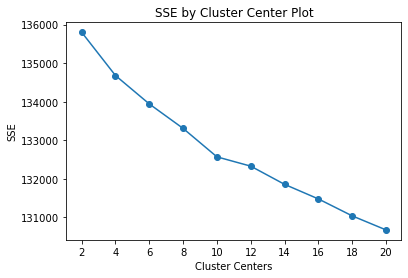

In [23]:
find_optimal_clusters(newsTFVects, 20)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters


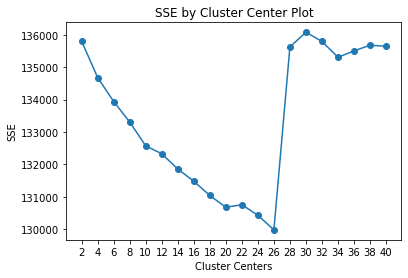

In [24]:
find_optimal_clusters(newsTFVects, 40)

Based on the elbow method, the best clustering number is 20

In [25]:
numClusters = 10
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsTFVects)

KMeans(n_clusters=10)

In [26]:
terms = tfidf_vectorizer.get_feature_names_out()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 vaccine
 virus
 covid
 people
 don
 gates
 just
 getting
 make
 vaccinated


Cluster 1:
 people
 virus
 like
 just
 covid
 vaccinated
 need
 world
 think
 know


Cluster 2:
 going
 people
 just
 virus
 like
 know
 biden
 trump
 happen
 think


Cluster 3:
 florida
 desantis
 governor
 state
 people
 covid
 don
 texas
 live
 ron


Cluster 4:
 trump
 president
 2020
 biden
 gates
 obama
 2015
 donald
 did
 like


Cluster 5:
 virus
 china
 gates
 just
 like
 biden
 covid
 world
 know
 right


Cluster 6:
 news
 fox
 fake
 cnn
 media
 trump
 just
 like
 msnbc
 faux


Cluster 7:
 don
 know
 want
 people
 trust
 believe
 just
 care
 like
 think


Cluster 8:
 lol
 trump
 right
 like
 just
 virus
 people
 know
 don
 think


Cluster 9:
 quot
 people
 trump
 just
 virus
 like
 covid
 don
 said
 know




# Topic Modeling: LDA

In [27]:
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(newsTFVects)

LatentDirichletAllocation(random_state=0)

In [28]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print("\n")

print_topics(lda, tfidf_vectorizer, n_top_words=10)

Topic #1:
quot thank tucker wow like evidence trump just believe say


Topic #2:
news fox fake lol cnn media msnbc bs evil joke


Topic #3:
people virus quot world gates let population brandon control don


Topic #4:
trump virus china gates obama 2020 knew lab did fauci


Topic #5:
quot good vaccine know covid agree people test like gates


Topic #6:
president biden trump god bless america joe people gates amen


Topic #7:
border yes dislike war jesus true open god people biden


Topic #8:
youtu exactly woman brave vaccinated hope vaccine variant right liar


Topic #9:
mask people don masks wear trump quot just want democrats


Topic #10:
youtube watch href vaccine amp covid people immune quot rate




In [33]:
import lucem_illud

tqdm.pandas(desc="Tokenizing and normalizing comments")
combined_df['tokenized_text'] = combined_df['Comment'].progress_apply(lambda x: lucem_illud.word_tokenize(x))
combined_df['normalized_tokens'] = combined_df['tokenized_text'].progress_apply(lambda x: lucem_illud.normalizeTokens(x))

Tokenizing and normalizing comments:   0%|          | 0/139587 [00:00<?, ?it/s]

Tokenizing and normalizing comments:   0%|          | 0/139587 [00:00<?, ?it/s]

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [34]:
combined_df

,Comment PublishedAt,Comment,Video PublishedAt,Video Title,Channel,tokenized_text,normalized_tokens
0,2023-09-12,Pathetic fear mongering,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[Pathetic, fear, mongering]","[pathetic, fear, mongering]"
1,2023-04-30,Prophetic,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,[Prophetic],[prophetic]
2,2023-03-16,Hey! First comment of 2023! Is it anniversary ...,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[Hey, First, comment, of, 2023, Is, it, annive...","[hey, comment, anniversary, day, china, virus]"
3,2022-09-12,It&#39;s kind of surreal to watch this now giv...,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[It&#39;s, kind, of, surreal, to, watch, this,...","[it&#39;s, kind, surreal, watch, given, tucker..."
4,2022-07-10,"I know I am 2 years late, but when did Tucker ...",2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[I, know, I, am, 2, years, late, but, when, di...","[know, years, late, tucker, trust, science]"
...,...,...,...,...,...,...,...
139582,2021-12-28,@@pohakumana4288 <br><br>We are talking about PR,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[@@pohakumana4288, <, br><br, >, We, are, talk...","[@@pohakumana4288, <, br><br, >, talking, pr]"
139583,2021-12-28,@@jlock9085 are you? because no one anywhere e...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[@@jlock9085, are, you, because, no, one, anyw...","[@@jlock9085, matters]"
139584,2021-12-28,Dislike,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,[Dislike],[dislike]
139585,2021-12-28,"from John Campbell today, UK confirmed 159,43...",2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[from, John, Campbell, today, UK, confirmed, 1...","[john, campbell, today, uk, confirmed, omicron..."


In [35]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

combined_df['reduced_tokens'] = combined_df['normalized_tokens'].apply(lambda x: dropMissing(x, tfidf_vectorizer.vocabulary_.keys()))

In [36]:
dictionary = gensim.corpora.Dictionary(combined_df['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in combined_df['reduced_tokens']]

gensim.corpora.MmCorpus.serialize('comment.mm', corpus)
senmm = gensim.corpora.MmCorpus('comment.mm')

In [37]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [38]:
ldaDF = pd.DataFrame({
        'comment' : combined_df['Comment'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in combined_df['reduced_tokens']]
    })

In [39]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,like,trump,virus,biden,desantis,gates,news,video,covid,children
1,florida,president,people,thank,world,people,msnbc,good,vaccinated,vaccine
2,evil,people,mask,joe,china,kids,media,child,people,know
3,little,covid,death,jesus,state,vaccines,stupid,yes,dislike,better
4,lies,vote,masks,god,pandemic,fauci,lol,parents,god,effects
5,talk,care,vaccine,mini,virus,vaccine,fake,youtube,amp,shot
6,ron,term,deaths,heart,america,money,facts,event,fear,covid
7,sad,years,cases,earth,country,need,guy,look,life,getting
8,bad,obama,year,survival,government,nt,truth,read,hope,exactly
9,afraid,dead,sick,texas,party,want,believe,seen,die,got


# Sinophobia

In [29]:
china_keywords = ['china', 'chinese', 'wuhan', 'ccp', 'kungflu', 'kung flu', 
                  'wuflu', 'chinesevirus', 'wuhanflu', 'chinazi', 'chink', 'sars', 
                  'communist', 'communism', 'bat', 'bioweapon']

In [40]:
china_keywords_mask = combined_df['normalized_tokens'].progress_apply(lambda tokens: any(keyword in tokens for keyword in china_keywords))
china_df = combined_df[china_keywords_mask]

Tokenizing and normalizing comments:   0%|          | 0/139587 [00:00<?, ?it/s]

In [41]:
china_df

,Comment PublishedAt,Comment,Video PublishedAt,Video Title,Channel,tokenized_text,normalized_tokens,reduced_tokens
2,2023-03-16,Hey! First comment of 2023! Is it anniversary ...,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[Hey, First, comment, of, 2023, Is, it, annive...","[hey, comment, anniversary, day, china, virus]","[hey, comment, day, china, virus]"
9,2021-03-26,Lora of good warnings here... that unfortunate...,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[Lora, of, good, warnings, here, that, unfortu...","[lora, good, warnings, unfortunately, true, sa...","[good, warnings, unfortunately, true, saying, ..."
18,2020-06-22,The Chinese Coronavirus.,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[The, Chinese, Coronavirus]","[chinese, coronavirus]","[chinese, coronavirus]"
21,2020-06-09,I bet his favorite food is Chinese food. Gtfoh,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[I, bet, his, favorite, food, is, Chinese, foo...","[bet, favorite, food, chinese, food, gtfoh]","[bet, favorite, food, chinese, food, gtfoh]"
23,2020-05-19,Did he just said that China is the most racist...,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[Did, he, just, said, that, China, is, the, mo...","[said, china, racist, country, world]","[said, china, racist, country, world]"
...,...,...,...,...,...,...,...,...
139445,2021-12-28,American pandemic experts? US 5 day iso...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[American, pandemic, experts, US, 5, day, isol...","[american, pandemic, experts, day, isolation, ...","[american, pandemic, experts, day, isolation, ..."
139506,2021-12-28,The great news as they will get natural immuni...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[The, great, news, as, they, will, get, natura...","[great, news, natural, immunity, won&#39;t, ne...","[great, news, natural, immunity, need, communi..."
139535,2021-12-28,Trump Trump Trump Trump Trump Trump and Cathol...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[Trump, Trump, Trump, Trump, Trump, Trump, and...","[trump, trump, trump, trump, trump, trump, cat...","[trump, trump, trump, trump, trump, trump, cat..."
139540,2021-12-28,Wow that great news and Puerto Rico is so luck...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[Wow, that, great, news, and, Puerto, Rico, is...","[wow, great, news, puerto, rico, lucky, united...","[wow, great, news, puerto, rico, lucky, united..."


### Clustering

In [42]:
custom_stop_words = ['http', 'https', 'www', 'com', 'net', 'org', 'io', '39', 'br', 'll'] # customize stop words
combined_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8, 
    max_features=10000,
    min_df=5, 
    stop_words=combined_stop_words,
    norm='l2'
)

# Train the vectorizer on the combined corpus
newsTFVects = tfidf_vectorizer.fit_transform(china_df['Comment'])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


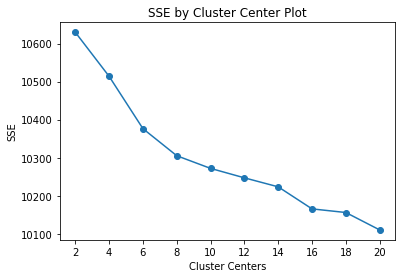

In [43]:
find_optimal_clusters(newsTFVects, 20)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters


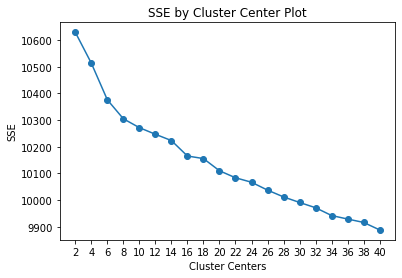

In [44]:
find_optimal_clusters(newsTFVects, 40)

In [45]:
numClusters = 10
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsTFVects)

KMeans(n_clusters=10)

In [46]:
terms = tfidf_vectorizer.get_feature_names_out()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 communist
 party
 chinese
 people
 china
 news
 country
 evil
 democrats
 virus


Cluster 1:
 biden
 china
 joe
 trump
 president
 communist
 ccp
 vote
 america
 2020


Cluster 2:
 nope
 ccp
 just
 user
 complicated
 useless
 china
 people
 does
 literally


Cluster 3:
 china
 virus
 came
 trump
 blame
 say
 like
 got
 corona
 covid


Cluster 4:
 china
 virus
 ccp
 trump
 people
 just
 like
 don
 covid
 did


Cluster 5:
 world
 china
 ccp
 virus
 war
 people
 chinese
 rest
 just
 trump


Cluster 6:
 wuhan
 lab
 fauci
 virus
 research
 gates
 funded
 obama
 china
 dr


Cluster 7:
 chinese
 government
 virus
 people
 like
 coronavirus
 china
 just
 ccp
 did


Cluster 8:
 quot
 virus
 china
 chinese
 people
 just
 trump
 wuhan
 world
 don


Cluster 9:
 ccp
 virus
 evil
 time
 china
 war
 world
 release
 called
 work




### Topic Modeling

In [48]:
dictionary = gensim.corpora.Dictionary(china_df['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in china_df['reduced_tokens']]

gensim.corpora.MmCorpus.serialize('comment.mm', corpus)
senmm = gensim.corpora.MmCorpus('comment.mm')

In [50]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

ldaDF = pd.DataFrame({
        'comment' : china_df['Comment'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in china_df['reduced_tokens']]
    })

In [51]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,gates,china,china,wuhan,virus,china,china,communist,event,china
1,wuhan,people,people,lab,china,virus,ccp,chinese,october,chinese
2,lab,trump,world,news,vaccine,vaccine,trump,party,foundation,virus
3,fauci,virus,trump,research,world,people,amp,people,china,world
4,virus,like,like,virus,covid,going,biden,media,wuhan,government
5,sars,chinese,virus,china,children,trump,virus,china,virus,people
6,obama,covid,chinese,function,research,chinese,world,virus,aids,pandemic
7,china,flu,country,gain,wuhan,communism,media,quot,hospitalized,covid
8,coronavirus,dr,think,bat,viruses,msnbc,america,world,board,know
9,pandemic,mask,time,fauci,lab,communist,msnbc,growth,scenario,said


### RoBERTa Hate Speech

In [52]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
model = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [53]:
import torch

def predict_hate_speech(comments):
    inputs = tokenizer(comments, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.softmax(logits, dim=-1)
    return probabilities[:, 1].tolist()[0]

In [54]:
tqdm.pandas(desc="Calculate hate speech score")

china_df['Hate Speech Score'] = china_df['Comment'].progress_apply(lambda x: predict_hate_speech(x))

Calculate hate speech score:   0%|          | 0/10901 [00:00<?, ?it/s]

/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_85457/1469583430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  china_df['Hate Speech Score'] = china_df['Comment'].progress_apply(lambda x: predict_hate_speech(x))


In [56]:
china_df.to_csv('sinophobic_comment.csv')

To determine an optimal hate speech score threshold, randomly sample 30 comments and manually label them with binary 0 or 1, then iteratively test with different threshold

In [60]:
sample_comments = china_df['Comment'].sample(n=50, random_state=42)

for i, comment in enumerate(sample_comments):
    print(i, ': ', comment)
    

0 :  The problem here is a damned if you do damned if you don&#39;t scenario. I have thought it was possible from the beginning that it was a manufactured virus, I have thought it was possible from the beginning that it was intentionally released. The first hurdle is proving if what she said is true from her research, and trusting that those vetting her research are not biased/influenced/or threatened with a counter agenda. The second hurdle, well, disproving her research does not mean the CCP were not negligible nor complicit, it just means her research does not prove it. But worst of all, what happens if she is right? Do we go to war? Lets say we just do sanctions, how is that justice? Lets say we want justice, that would mean war, and given the military and resources they have gained in the last half a century, how well will that turn out for the world? How much land, resources, politicians, celebrities do they own in the west? How much corrupted tech have they sold into use in the 

In [63]:
sample_comments = china_df.sample(n=50, random_state=42)
hate_scores = []
for index, row in sample_comments.iterrows():
    print(f"Comment: {row['Comment']}")
    print(f"Hate Speech Score: {row['Hate Speech Score']}")
    hate_scores.append(row['Hate Speech Score'])
    print('---')

Comment: The problem here is a damned if you do damned if you don&#39;t scenario. I have thought it was possible from the beginning that it was a manufactured virus, I have thought it was possible from the beginning that it was intentionally released. The first hurdle is proving if what she said is true from her research, and trusting that those vetting her research are not biased/influenced/or threatened with a counter agenda. The second hurdle, well, disproving her research does not mean the CCP were not negligible nor complicit, it just means her research does not prove it. But worst of all, what happens if she is right? Do we go to war? Lets say we just do sanctions, how is that justice? Lets say we want justice, that would mean war, and given the military and resources they have gained in the last half a century, how well will that turn out for the world? How much land, resources, politicians, celebrities do they own in the west? How much corrupted tech have they sold into use in 

In [61]:
# I manually look through all 50 sampled comments and label them, 1 means hate speech and 0 otherwise
manual_labels = [1,0,0,1,0,1,1,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,1,1,1,1]

50

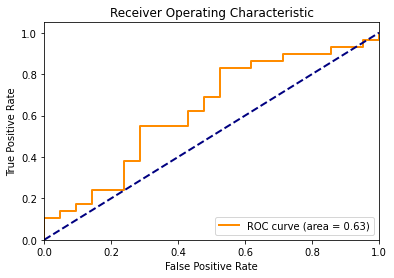

In [65]:
manual_labels = np.array(manual_labels)
hate_scores = np.array(hate_scores)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, roc_thresholds = roc_curve(manual_labels, hate_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [68]:
fpr, tpr, thresholds = roc_curve(manual_labels, hate_scores)
# Calculate the distance to the top-left corner for each point
distances = (fpr**2 + (1-tpr)**2)**0.5
# Find the minimum distance and the corresponding optimal threshold
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.3421958088874817

Hence set a hate speech threshold to be 0.34 and add a new binary column "Hate Speech" based on "Hate Speech Score"

In [69]:
china_df['Hate Speech'] = china_df['Hate Speech Score'].apply(lambda score: 1 if score > optimal_threshold else 0)

/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_85457/2861758994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  china_df['Hate Speech'] = china_df['Hate Speech Score'].apply(lambda score: 1 if score > optimal_threshold else 0)


In [72]:
china_df

,Comment PublishedAt,Comment,Video PublishedAt,Video Title,Channel,tokenized_text,normalized_tokens,reduced_tokens,Hate Speech Score,Hate Speech
2,2023-03-16,Hey! First comment of 2023! Is it anniversary ...,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[Hey, First, comment, of, 2023, Is, it, annive...","[hey, comment, anniversary, day, china, virus]","[hey, comment, day, china, virus]",0.685360,1
9,2021-03-26,Lora of good warnings here... that unfortunate...,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[Lora, of, good, warnings, here, that, unfortu...","[lora, good, warnings, unfortunately, true, sa...","[good, warnings, unfortunately, true, saying, ...",0.320128,0
18,2020-06-22,The Chinese Coronavirus.,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[The, Chinese, Coronavirus]","[chinese, coronavirus]","[chinese, coronavirus]",0.000340,0
21,2020-06-09,I bet his favorite food is Chinese food. Gtfoh,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[I, bet, his, favorite, food, is, Chinese, foo...","[bet, favorite, food, chinese, food, gtfoh]","[bet, favorite, food, chinese, food, gtfoh]",0.999489,1
23,2020-05-19,Did he just said that China is the most racist...,2020-03-09,Tucker: We must remain calm but not complacent...,Fox,"[Did, he, just, said, that, China, is, the, mo...","[said, china, racist, country, world]","[said, china, racist, country, world]",0.000678,0
...,...,...,...,...,...,...,...,...,...,...
139445,2021-12-28,American pandemic experts? US 5 day iso...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[American, pandemic, experts, US, 5, day, isol...","[american, pandemic, experts, day, isolation, ...","[american, pandemic, experts, day, isolation, ...",0.001411,0
139506,2021-12-28,The great news as they will get natural immuni...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[The, great, news, as, they, will, get, natura...","[great, news, natural, immunity, won&#39;t, ne...","[great, news, natural, immunity, need, communi...",0.710858,1
139535,2021-12-28,Trump Trump Trump Trump Trump Trump and Cathol...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[Trump, Trump, Trump, Trump, Trump, Trump, and...","[trump, trump, trump, trump, trump, trump, cat...","[trump, trump, trump, trump, trump, trump, cat...",0.317390,0
139540,2021-12-28,Wow that great news and Puerto Rico is so luck...,2021-12-28,Puerto Rico Covid Cases Soar Nearly 2800% In T...,MSNBC,"[Wow, that, great, news, and, Puerto, Rico, is...","[wow, great, news, puerto, rico, lucky, united...","[wow, great, news, puerto, rico, lucky, united...",0.698143,1


In [71]:
china_df['Hate Speech'].sum()

4774

#### Hate Speech Score - Hate Intensity

In [73]:
china_df['Hate Speech Score'].describe()

count    10901.000000
mean         0.396057
std          0.403771
min          0.000131
25%          0.008723
50%          0.203034
75%          0.861640
max          0.999800
Name: Hate Speech Score, dtype: float64

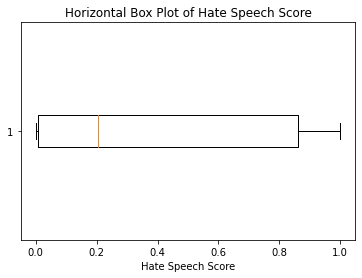

In [74]:
plt.boxplot(china_df['Hate Speech Score'], vert=False)
plt.title('Horizontal Box Plot of Hate Speech Score')
plt.xlabel('Hate Speech Score')

plt.show()

<AxesSubplot:title={'center':'Hate Score Distribution'}, ylabel='Frequency'>

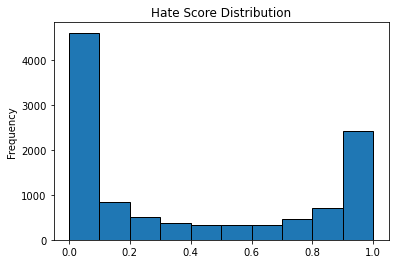

In [75]:
china_df['Hate Speech Score'].plot(kind='hist', edgecolor='black', title='Hate Score Distribution')

In [77]:
china_df.dtypes

Comment PublishedAt           object
Comment                       object
Video PublishedAt      datetime64[s]
Video Title                   object
Channel                       object
tokenized_text                object
normalized_tokens             object
reduced_tokens                object
Hate Speech Score            float64
Hate Speech                    int64
dtype: object

In [81]:
monthly_hate_speech_scores = china_df.groupby(pd.Grouper(key='Video PublishedAt', freq='M'))['Hate Speech Score'].mean().reset_index()
monthly_hate_speech_scores['Video PublishedAt'] = monthly_hate_speech_scores['Video PublishedAt'].dt.strftime('%Y-%m')

# Rename the columns for clarity
monthly_hate_speech_scores.columns = ['Month', 'Average Hate Speech Score']
monthly_hate_speech_scores

,Month,Average Hate Speech Score
0,2020-01,0.441886
1,2020-02,0.443404
2,2020-03,0.386435
3,2020-04,0.322001
4,2020-05,0.383086
5,2020-06,0.475127
6,2020-07,0.372409
7,2020-08,0.365997
8,2020-09,0.417827
9,2020-10,0.290872


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

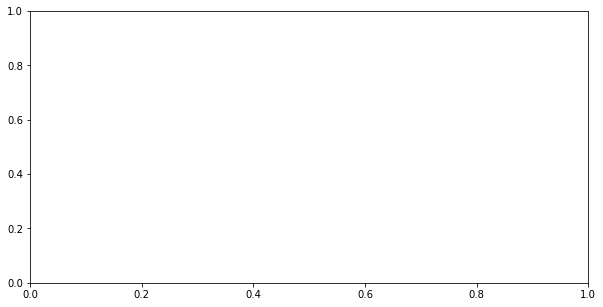

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_hate_speech_scores['Month'], monthly_hate_speech_scores['Average Hate Speech Score'], marker='o')
plt.title('Average Hate Speech Score Over 2020 and 2021')
plt.xlabel('Month')
plt.ylabel('Average Hate Speech Score')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()